# 🏠🚆 Swiss Housing & Commute Explorer — Notebook

This notebook reconstructs the core pipeline behind the **Swiss Housing & Commute Explorer** app.  
It combines **BFS vacancy shares** (Leerwohnungszählung), **SBB GTFS** public transport schedules (all PT modes), and Swiss **Gemeinden** geometries to compute commute-aware housing preference scores and visualize them.

---

### 📑 Contents

1) **SETUP** — imports, paths, constants  
2) **HELPERS** — robust BFS CSV reader and parsing utilities  
3) **VACANCY DATA** — load BFS vacancy indicator  
4) **MUNICIPALITIES** — load Swiss Gemeinden and join vacancy  
5) **GTFS DATA** — load and preprocess SBB GTFS feed  
6) **COMMUTE** — function and travel times from a chosen origin  
7) **PREFERENCE SCORE** — compute (with fallback if times are missing)  
8) **PLOT — Single choropleth** (choose one of: Vacancy **or** Commute **or** Preference)

---

> **Note:** Keep one figure per plotting cell to ensure clean rendering (especially on some environments).

In [1]:
# 1) SETUP — imports, paths, constants
from pathlib import Path
import io, json, re, time, urllib.request
import numpy as np
import pandas as pd
import geopandas as gpd

# --- Resolve repo and data directory robustly ---
def _find_repo_root() -> Path:
    """Walk up from CWD to find the repo root (expects data/ folder)."""
    here = Path.cwd().resolve()
    for root in [here, *here.parents]:
        if (root / "data").is_dir():
            return root
    return here  # fallback if not found

REPO_ROOT = _find_repo_root()
DATA_DIR = (REPO_ROOT / "data").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

VACANCY_CSV = DATA_DIR / "vacancy_municipality.csv"
GTFS_ZIP    = DATA_DIR / "gtfs_train.zip"

# --- Download files from GitHub if missing (works in Colab) ---
URL_VACANCY = "https://raw.githubusercontent.com/ingo-stallknecht/swiss-commute-housing/main/data/vacancy_municipality.csv"
URL_GTFS    = "https://raw.githubusercontent.com/ingo-stallknecht/swiss-commute-housing/main/data/gtfs_train.zip"

def _download_if_missing(url: str, dest: Path):
    if dest.exists() and dest.stat().st_size > 0:
        print(f"[ok] Already present: {dest.name} ({dest.stat().st_size:,} bytes)")
        return
    print(f"[dl] Downloading {url} -> {dest}")
    urllib.request.urlretrieve(url, dest)
    print(f"[ok] Wrote {dest} ({dest.stat().st_size:,} bytes)")

_download_if_missing(URL_VACANCY, VACANCY_CSV)
_download_if_missing(URL_GTFS,    GTFS_ZIP)

# --- Print resolved paths ---
print("[paths]")
print("  CWD       :", Path.cwd())
print("  REPO_ROOT :", REPO_ROOT)
print("  DATA_DIR  :", DATA_DIR)
print("  vacancy   :", VACANCY_CSV, "(exists:", VACANCY_CSV.exists(), ")")
print("  gtfs zip  :", GTFS_ZIP, "(exists:", GTFS_ZIP.exists(), ")")

# Coordinate Reference Systems
CRS_WGS84 = "EPSG:4326"
CRS_CH    = "EPSG:2056"

# --- Timer helper ---
def timer(msg: str):
    t0 = time.time()
    print(f"[start] {msg}")
    def _end():
        print(f"[done ] {msg} in {time.time() - t0:.2f}s")
    return _end

[ok] Already present: vacancy_municipality.csv (740,810 bytes)
[ok] Already present: gtfs_train.zip (19,439,531 bytes)
[paths]
  CWD       : C:\Users\Ingo\Desktop\swiss-commute-housing\notebooks
  REPO_ROOT : C:\Users\Ingo\Desktop\swiss-commute-housing
  DATA_DIR  : C:\Users\Ingo\Desktop\swiss-commute-housing\data
  vacancy   : C:\Users\Ingo\Desktop\swiss-commute-housing\data\vacancy_municipality.csv (exists: True )
  gtfs zip  : C:\Users\Ingo\Desktop\swiss-commute-housing\data\gtfs_train.zip (exists: True )


In [2]:
# 2) HELPERS — robust BFS CSV reader and parsing utilities

def _detect_header_index(lines: list[str]) -> int:
    pat = re.compile(r"(TIME_PERIOD|Zeitperiode).*(OBS_VALUE|Beobachtungswert)", re.I)
    for i, ln in enumerate(lines[:300]):
        if pat.search(ln):
            return i
    # Fallback: first non-empty line
    for i, ln in enumerate(lines):
        if ln.strip():
            return i
    return 0

def _choose_sep(sample: str) -> str:
    # BFS often uses semicolons; auto-choose on the header sample
    return ";" if sample.count(";") >= sample.count(",") and sample.count(";") > 0 else ","

def _read_text_with_encodings(path: Path) -> str:
    tried = ("utf-8-sig", "utf-8", "latin1", "cp1252", "utf-16", "utf-16-le", "utf-16-be")
    for enc in tried:
        try:
            return path.read_text(encoding=enc)
        except Exception:
            pass
    # Last resort: best-effort decode
    return path.read_bytes().decode("utf-8", errors="ignore")

def read_bfs_like_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path.resolve()}")
    text = _read_text_with_encodings(path)
    lines = text.splitlines()
    hdr_idx = _detect_header_index(lines)
    body = "\n".join(lines[hdr_idx:])
    sep = _choose_sep("\n".join(lines[hdr_idx : hdr_idx + 5]))
    try:
        df = pd.read_csv(io.StringIO(body), sep=sep, engine="python", dtype=str)
    except Exception:
        alt = ";" if sep == "," else ","
        df = pd.read_csv(io.StringIO(body), sep=alt, engine="python", dtype=str)
    df.columns = [c.strip() for c in df.columns]
    return df

def parse_percent(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).strip().replace("\xa0", " ").replace("%", "")
    s = s.replace("’", "").replace("'", "").replace(" ", "").replace(",", ".")
    try:
        v = float(s)
    except Exception:
        return np.nan
    # If the file reports "51" for 51%, convert to 0.51 (BFS can vary by export)
    return v / 100.0 if v > 10 else v

In [3]:
# 3) VACANCY DATA — load BFS vacancy indicator

t_end = timer("Load BFS vacancy indicator")
df_raw = read_bfs_like_csv(VACANCY_CSV)

# Column aliases (language can vary)
COL_GEM_CANDIDATES   = ["Gemeinden", "Grossregionen, Kantone, Bezirke und Gemeinden", "GEO", "GEO/TIME", "Region"]
COL_ROOMS_CANDIDATES = ["Anzahl Zimmer", "Rooms", "Zimmerzahl", "Zimmer"]
COL_TYPE_CANDIDATES  = ["Typ der leer stehenden Wohnung", "Wohnungstyp", "Dwelling type", "Type"]
COL_MEAS_CANDIDATES  = ["Art der Messung", "Measure", "Messart"]
COL_VAL_CANDIDATES   = ["OBS_VALUE", "Beobachtungswert", "Value", "Wert"]

def _first_col(df: pd.DataFrame, names: list[str]) -> str:
    # Try exact first, then fuzzy contains (case-insensitive)
    for n in names:
        if n in df.columns:
            return n
    low = {c.lower(): c for c in df.columns}
    for n in names:
        n_low = n.lower()
        for lc, orig in low.items():
            if n_low in lc:
                return orig
    raise KeyError(f"Expected one of {names} in columns: {list(df.columns)}")

COL_GEM   = _first_col(df_raw, COL_GEM_CANDIDATES)
COL_ROOMS = _first_col(df_raw, COL_ROOMS_CANDIDATES)
COL_TYPE  = _first_col(df_raw, COL_TYPE_CANDIDATES)
COL_MEAS  = _first_col(df_raw, COL_MEAS_CANDIDATES)
COL_VAL   = _first_col(df_raw, COL_VAL_CANDIDATES)

df = df_raw.copy()
df["key_name"] = df[COL_GEM].astype(str).str.strip()

# Keep totals only
m_rooms = df[COL_ROOMS].astype(str).str.lower().isin(["total", "_t", "gesamt", "alle", "all"])
# 👇 use a non-capturing group to avoid the warning
m_type  = df[COL_TYPE ].astype(str).str.lower().str.contains(r"\b(?:alle|all)\b", regex=True, na=False)
m_meas  = df[COL_MEAS ].astype(str).str.lower().str.contains("anteil|share|percent|percentage", na=False)

df = df[m_rooms & m_type & m_meas].copy()
df["vacancy_pct"] = df[COL_VAL].map(parse_percent)

t_end()
print("Rows after filters:", len(df))
print("Non-null vacancy share:", int(df["vacancy_pct"].notna().sum()))

[start] Load BFS vacancy indicator
[done ] Load BFS vacancy indicator in 0.04s
Rows after filters: 2115
Non-null vacancy share: 2115


In [4]:
# 4) MUNICIPALITIES — load Swiss Gemeinden and join vacancy

import geopandas as gpd
import pandas as pd
import numpy as np
import re

CRS_WGS84 = "EPSG:4326"
CRS_CH    = "EPSG:2056"

URL_GEM = (
    "https://data.opendatasoft.com/explore/dataset/"
    "georef-switzerland-gemeinde-millesime%40public/download/"
    "?format=geojson&timezone=Europe%2FBerlin"
)

def safe_to_crs(gdf, crs):
    g = gdf.copy()
    try:
        if g.crs is None:
            return g.set_crs(crs)
        elif str(g.crs).lower() != str(crs).lower():
            return g.to_crs(crs)
    except Exception:
        pass
    return g

def norm_name(s: str) -> str:
    if pd.isna(s): 
        return s
    s = str(s)
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue")
           .replace("Ä","ae").replace("Ö","oe").replace("Ü","ue")
           .replace("ß","ss"))
    s = s.encode("ascii","ignore").decode("ascii")
    s = re.sub(r"[^A-Za-z0-9]+","", s).lower()
    return s

t_end = timer("Load Swiss Gemeinde geometries")
try:
    gdf_all = gpd.read_file(URL_GEM)[
        ["gem_name","gem_code","kan_code","year","geometry"]
    ].rename(
        columns={
            "gem_name":"GEMEINDE_NAME",
            "gem_code":"GEMEINDE_CODE",
            "kan_code":"KANTON_CODE"
        }
    )
except Exception:
    # Fallback to local, if you already have it (e.g. exported previously)
    local_gj = Path("app/data/gemeinden_simplified.geojson")
    assert local_gj.exists(), "Unable to download geometries and no local fallback at app/data/."
    gdf_all = gpd.read_file(local_gj)
    if "year" not in gdf_all.columns:
        gdf_all["year"] = pd.Timestamp.today().year
latest_geom_year = gdf_all["year"].max()
gdf = (
    gdf_all[gdf_all["year"] == latest_geom_year]
    .sort_values(["GEMEINDE_CODE","year"])
    .drop_duplicates("GEMEINDE_CODE", keep="last")
    .copy()
)
gdf = safe_to_crs(gdf.set_geometry(gdf.geometry.buffer(0)), CRS_CH)
t_end()

# ---- Join vacancy (df from previous cell) ----
NAME_MAP_RAW = {
    "Biel": "Biel/Bienne", "Bienne": "Biel/Bienne",
    "Leubringen": "Evilard",
    "Saint Imier": "Saint-Imier", "St Imier": "Saint-Imier", "St-Imier": "Saint-Imier",
    "Münster (BE)": "Moutier",
}

ind = df.copy()
ind["key_name_fix"] = ind["key_name"].map(lambda s: NAME_MAP_RAW.get(str(s).strip(), s))
ind = (ind.groupby("key_name_fix", as_index=False)["vacancy_pct"]
          .mean()
          .rename(columns={"key_name_fix":"key_name"}))

gdf["key_norm"] = gdf["GEMEINDE_NAME"].map(norm_name)
ind["key_norm"] = ind["key_name"].map(norm_name)
g = gdf.merge(ind[["key_norm","vacancy_pct"]], on="key_norm", how="left")

# Drop known non-municipals (lakes, etc.)
NON_MUNI_EXACT = {
    "Zürichsee (ZH)","Thunersee","Brienzersee","Bielersee (BE)","Bielersee (NE)",
    "Lac de Neuchâtel (BE)","Lac de Neuchâtel (NE)","Bodensee (SG)","Bodensee (TG)","Staatswald Galm"
}
mask_non = g["GEMEINDE_NAME"].isin(NON_MUNI_EXACT) | g["GEMEINDE_NAME"].str.contains(r"^Comunanza\b", case=False, na=False)
g = g.loc[~mask_non].copy()

print("Gemeinden:", len(g), "| vacancy coverage:", g["vacancy_pct"].notna().mean().round(3))

[start] Load Swiss Gemeinde geometries


Skipping field geo_point_2d: unsupported OGR type: 3


[done ] Load Swiss Gemeinde geometries in 99.54s
Gemeinden: 2116 | vacancy coverage: 0.995


In [5]:
# 5) GTFS DATA — load and preprocess SBB GTFS feed
import zipfile

t_end = timer("Load GTFS data")

GTFS_DIR = DATA_DIR / "gtfs_unzipped"
if not GTFS_DIR.exists():
    with zipfile.ZipFile(GTFS_ZIP, "r") as zf:
        zf.extractall(GTFS_DIR)

# --- Clean GTFS reads (no DtypeWarning) ---
read_opts = dict(low_memory=False)

stops = pd.read_csv(
    GTFS_DIR / "stops.txt",
    dtype={"stop_id": str, "parent_station": str, "stop_lat": float, "stop_lon": float},
    **read_opts,
)

trips = pd.read_csv(
    GTFS_DIR / "trips.txt",
    dtype={"route_id": str, "trip_id": str, "service_id": str},
    **read_opts,
)

routes = pd.read_csv(
    GTFS_DIR / "routes.txt",
    dtype={"route_id": str, "route_type": "Int64", "agency_id": str},
    **read_opts,
)

stop_times = pd.read_csv(
    GTFS_DIR / "stop_times.txt",
    dtype={
        "trip_id": str,
        "stop_id": str,
        "arrival_time": str,
        "departure_time": str,
        "stop_sequence": "Int64",
    },
    **read_opts,
)

t_end()
print(f"Stations: {len(stops)} | Trips: {len(trips)} | Routes: {len(routes)} | StopTimes: {len(stop_times)}")

[start] Load GTFS data
[done ] Load GTFS data in 4.47s
Stations: 6868 | Trips: 210069 | Routes: 118995 | StopTimes: 2237319


In [6]:
# 6) COMMUTE — function and travel times from a chosen origin
from collections import defaultdict
from shapely.geometry import Point

# --- Build station_id (parent_station fallback) ---
stops = stops.copy()
stops["stop_id"] = stops["stop_id"].astype(str)
stops["parent_station"] = stops["parent_station"].astype(str)
stops["station_id"] = stops["parent_station"].where(stops["parent_station"].notna(), stops["stop_id"]).astype(str)

# --- Keep all transit modes (rail, tram, metro, bus, ferry, cable, gondola, funicular) ---
USE_ROUTE_TYPES = {0, 1, 2, 3, 4, 5, 6, 7}
sel_route_ids = routes[routes["route_type"].isin(USE_ROUTE_TYPES)]["route_id"].astype(str).unique()
sel_trips = trips[trips["route_id"].astype(str).isin(sel_route_ids)]["trip_id"].astype(str).unique()

st_times = stop_times[stop_times["trip_id"].astype(str).isin(sel_trips)].copy()
st_times["stop_id"] = st_times["stop_id"].astype(str)
st_times = st_times.merge(stops[["stop_id", "station_id"]], on="stop_id", how="left")

# --- HMS → seconds ---
def hms_to_sec(x: str) -> float:
    try:
        h, m, s = str(x).split(":")
        return int(h) * 3600 + int(m) * 60 + int(s)
    except Exception:
        return np.nan

st_times = st_times.dropna(subset=["arrival_time", "departure_time", "station_id"]).copy()
st_times["arr_s"] = st_times["arrival_time"].map(hms_to_sec)
st_times["dep_s"] = st_times["departure_time"].map(hms_to_sec)
st_times = st_times.dropna(subset=["arr_s", "dep_s"])

# Sort within trip and build edges (u→v with weight seconds)
st_times.sort_values(["trip_id", "stop_sequence"], inplace=True)
st_times["next_station"] = st_times.groupby("trip_id")["station_id"].shift(-1)
st_times["next_arr_s"] = st_times.groupby("trip_id")["arr_s"].shift(-1)

edges_raw = st_times.dropna(subset=["next_station", "next_arr_s"])[
    ["station_id", "next_station", "dep_s", "next_arr_s"]
].copy()
edges_raw["w_sec"] = (edges_raw["next_arr_s"] - edges_raw["dep_s"]).astype(float)

# Take the minimum observed time per (u,v)
edge_min = (
    edges_raw.groupby(["station_id", "next_station"], as_index=False)["w_sec"]
    .min()
    .rename(columns={"station_id": "u", "next_station": "v"})
)
edge_min["u"] = edge_min["u"].astype(str)
edge_min["v"] = edge_min["v"].astype(str)

# --- Station geometries (LV95) ---
stops_xy = stops[["station_id", "stop_lon", "stop_lat"]].dropna().drop_duplicates().copy()
stops_xy["stop_lon"] = pd.to_numeric(stops_xy["stop_lon"], errors="coerce")
stops_xy["stop_lat"] = pd.to_numeric(stops_xy["stop_lat"], errors="coerce")
stops_xy = stops_xy.dropna(subset=["stop_lon", "stop_lat"])

stations_g = gpd.GeoDataFrame(
    stops_xy, geometry=gpd.points_from_xy(stops_xy["stop_lon"], stops_xy["stop_lat"]), crs=CRS_WGS84
).to_crs(CRS_CH)
# dissolve ensures unique station_id geometry; then set to centroid
stations_pts = stations_g.dissolve(by="station_id", as_index=False)
stations_pts["geometry"] = stations_pts.geometry.centroid

# Dict of station_id -> (x, y) in meters (LV95)
stxy = stations_pts.set_index("station_id")["geometry"].apply(lambda p: (p.x, p.y)).to_dict()

# --- Edge sanitization: min time, speed ceiling ---
def sanitize_edges(edges_df, stxy_dict, min_sec=20.0, vmax_kmh=160.0):
    u_xy = edges_df["u"].map(stxy_dict)
    v_xy = edges_df["v"].map(stxy_dict)
    dx = np.array([a[0] - b[0] if (isinstance(a, tuple) and isinstance(b, tuple)) else np.nan for a, b in zip(u_xy, v_xy)])
    dy = np.array([a[1] - b[1] if (isinstance(a, tuple) and isinstance(b, tuple)) else np.nan for a, b in zip(u_xy, v_xy)])
    dist_m = np.hypot(dx, dy)
    w = edges_df["w_sec"].astype(float).to_numpy()
    w = np.where(~np.isfinite(w) | (w < min_sec), min_sec, w)
    vmax_mps = vmax_kmh / 3.6
    bad = (dist_m > 0) & (dist_m / w > vmax_mps)
    w[bad] = np.maximum(dist_m[bad] / vmax_mps, min_sec)
    out = edges_df.copy()
    out["w_sec"] = w
    return out.dropna(subset=["w_sec"])

edge_sane = sanitize_edges(edge_min, stxy)

# --- Build adjacency list for Dijkstra ---
adj = defaultdict(list)
for r in edge_sane.itertuples(index=False):
    adj[r.u].append((r.v, float(r.w_sec)))

print(f"Station graph: {len(edge_sane)} edges | stations: {len(stations_pts)}")

# ---------- Matching & shortest-path helpers ----------

def _normtxt(s: str) -> str:
    return (
        str(s).lower()
        .replace("ä", "a").replace("ö", "o").replace("ü", "u")
        .replace("é", "e").replace("è", "e").replace("ê", "e")
        .strip()
    )

def match_station_ids_by_name(name: str):
    """Prefer exact normalized name, else prefix, else substring."""
    name_map = (stops.groupby("station_id")["stop_name"].agg(lambda s: s.value_counts().idxmax()))
    n0 = _normtxt(name)
    exact = [sid for sid, nm in name_map.items() if isinstance(nm, str) and _normtxt(nm) == n0]
    if exact:
        return sorted({str(x) for x in exact})
    starts = [sid for sid, nm in name_map.items() if isinstance(nm, str) and _normtxt(nm).startswith(n0)]
    if starts:
        return sorted({str(x) for x in starts})
    contains = [sid for sid, nm in name_map.items() if isinstance(nm, str) and n0 in _normtxt(nm)]
    return sorted({str(x) for x in contains})

def dijkstra_from_sources(src_ids):
    """Multi-source Dijkstra on the station graph. Uses global `adj`."""
    import heapq
    INF = 10**12
    dist = {sid: 0.0 for sid in src_ids}
    pq = [(0.0, sid) for sid in src_ids]
    heapq.heapify(pq)
    seen = set()
    while pq:
        d, u = heapq.heappop(pq)
        if u in seen:
            continue
        seen.add(u)
        for v, w in adj.get(u, []):
            nd = d + w
            if nd < dist.get(v, INF):
                dist[v] = nd
                heapq.heappush(pq, (nd, v))
    return pd.DataFrame({"station_id": list(dist.keys()), "time_sec_station": list(dist.values())})

def _ensure_lv95(gdf):
    if gdf.crs is None:
        try:
            gdf = gdf.set_crs(2056)
        except Exception:
            pass
    if str(gdf.crs).lower() != "epsg:2056":
        gdf = gdf.to_crs(2056)
    return gdf

# --- Main API used later ---
K_NEAREST_ST = 5
WALK_KMPH = 5.0
WALK_M_PER_MIN = (WALK_KMPH * 1000) / 60.0
MAX_WALK_M = 15000
SOFTMIN_TAU_MIN = 8.0
SMOOTH_SIGMA_M = 20000.0
VMAX_GLOBAL_KMH = 160.0
BOARD_MIN = 4.0

def _union_all_geoms(geoms):
    try:
        from shapely import union_all as _u
        return _u(list(geoms))
    except Exception:
        from shapely.ops import unary_union as _uu
        return _uu(list(geoms))

def compute_commute_minutes_from(origin_name: str, g_polys: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    Compute minutes per Gemeinde from an origin station name.
    Requires globals: stops, stations_pts, adj (built above).
    """
    assert {"GEMEINDE_CODE", "geometry"} <= set(g_polys.columns), \
        "g_polys must have ['GEMEINDE_CODE','geometry']"

    g_polys = _ensure_lv95(g_polys)

    seed_ids = match_station_ids_by_name(origin_name)
    if not seed_ids:
        raise ValueError(f"No station found for '{origin_name}'")

    # 1) Station-level shortest paths
    dist_df = dijkstra_from_sources(seed_ids)
    st_pts = stations_pts.merge(dist_df, on="station_id", how="left")
    valid = st_pts.dropna(subset=["time_sec_station"]).copy()
    if valid.empty:
        return g_polys[["GEMEINDE_CODE"]].assign(avg_travel_min=np.nan)

    # 2) In-polygon mean (rail minutes)
    st_in = gpd.sjoin(
        valid[["station_id", "time_sec_station", "geometry"]],
        g_polys[["GEMEINDE_CODE", "geometry"]],
        how="left", predicate="within"
    ).dropna(subset=["GEMEINDE_CODE"])
    inpoly = st_in.groupby("GEMEINDE_CODE", as_index=False)["time_sec_station"].mean()
    inpoly["avg_travel_min"] = inpoly["time_sec_station"] / 60.0
    inpoly = inpoly[["GEMEINDE_CODE", "avg_travel_min"]]

    # 3) Soft-min via K nearest (rail + walk)
    g_cent = g_polys.copy()
    g_cent["centroid"] = g_cent.geometry.representative_point()
    g_cent = g_cent.set_geometry("centroid")

    cand = valid[["station_id", "time_sec_station", "geometry"]].copy()
    nearest = []
    for k in range(K_NEAREST_ST):
        kn = gpd.sjoin_nearest(g_cent, cand, how="left", distance_col=f"dist_m_{k}")
        if "GEMEINDE_CODE_left" in kn.columns:
            kn = kn.rename(columns={"GEMEINDE_CODE_left": "GEMEINDE_CODE"})
        if "time_sec_station_right" in kn.columns:
            kn = kn.rename(columns={"time_sec_station_right": f"time_sec_{k}"})
        elif "time_sec_station" in kn.columns:
            kn = kn.rename(columns={"time_sec_station": f"time_sec_{k}"})
        if "station_id_right" in kn.columns:
            kn = kn.rename(columns={"station_id_right": f"sid_{k}"})
        elif "station_id" in kn.columns:
            kn = kn.rename(columns={"station_id": f"sid_{k}"})
        nearest.append(kn[["GEMEINDE_CODE", f"sid_{k}", f"time_sec_{k}", f"dist_m_{k}"]].copy())

        matched = kn.get(f"sid_{k}", pd.Series(dtype=object)).dropna().astype(str).unique().tolist()
        if matched:
            cand = cand[~cand["station_id"].astype(str).isin(matched)].copy()

    knn = nearest[0]
    for tdf in nearest[1:]:
        knn = knn.merge(tdf, on="GEMEINDE_CODE", how="left")

    tot_cols = []
    for k in range(K_NEAREST_ST):
        dcol, tcol = f"dist_m_{k}", f"time_sec_{k}"
        if dcol in knn.columns and tcol in knn.columns:
            knn[dcol] = np.minimum(pd.to_numeric(knn[dcol], errors="coerce").fillna(np.inf), MAX_WALK_M)
            walk_min = knn[dcol] / WALK_M_PER_MIN
            rail_min = pd.to_numeric(knn[tcol], errors="coerce") / 60.0
            knn[f"total_min_{k}"] = rail_min + walk_min
            tot_cols.append(f"total_min_{k}")

    if tot_cols:
        arr = knn[tot_cols].to_numpy(dtype="float64")
        arr = np.where(np.isfinite(arr), arr, np.inf)
        Z = np.exp(-np.clip(arr, 0, np.inf) / SOFTMIN_TAU_MIN)
        Z[arr == np.inf] = 0.0
        soft = -SOFTMIN_TAU_MIN * np.log(np.clip(Z.sum(axis=1), 1e-9, np.inf))
        knn_out = pd.DataFrame({"GEMEINDE_CODE": knn["GEMEINDE_CODE"].values, "softmin_min": soft})
    else:
        knn_out = pd.DataFrame({"GEMEINDE_CODE": knn["GEMEINDE_CODE"].values, "softmin_min": np.nan})

    comb = g_polys[["GEMEINDE_CODE", "geometry"]].merge(inpoly, on="GEMEINDE_CODE", how="left")
    comb = comb.merge(knn_out, on="GEMEINDE_CODE", how="left")
    comb["avg_travel_min"] = comb["avg_travel_min"].fillna(comb["softmin_min"]).astype(float)
    comb = comb.drop(columns=["softmin_min"])

    # Physics floor + origin=0 rule
    seeds_geom = stations_pts.loc[stations_pts["station_id"].isin(seed_ids), "geometry"]
    if len(seeds_geom) == 0:
        seeds_geom = stations_pts.iloc[:1]["geometry"]
    origin_pt = _union_all_geoms(seeds_geom).centroid

    rep_pts = comb["geometry"].representative_point()
    dist_m = rep_pts.distance(origin_pt).to_numpy(dtype="float64")
    floor_min = BOARD_MIN + (dist_m / 1000.0) / VMAX_GLOBAL_KMH * 60.0
    comb["avg_travel_min"] = np.maximum(comb["avg_travel_min"].to_numpy(dtype="float64"), floor_min)

    origin_code = g_polys.loc[g_polys.contains(origin_pt), "GEMEINDE_CODE"]
    if not origin_code.empty:
        comb.loc[comb["GEMEINDE_CODE"] == origin_code.iloc[0], "avg_travel_min"] = 0.0

    # Length-safe Gaussian smoothing
    base = g_polys.copy()
    base["centroid"] = base.geometry.representative_point()
    base = base.set_geometry("centroid")

    src = base.merge(comb[["GEMEINDE_CODE", "avg_travel_min"]], on="GEMEINDE_CODE", how="inner")
    src = src.dropna(subset=["avg_travel_min"])

    if len(src) == 0:
        return comb[["GEMEINDE_CODE", "avg_travel_min"]]

    bx = base.geometry.x.to_numpy(dtype="float64")
    by = base.geometry.y.to_numpy(dtype="float64")
    sx = src.geometry.x.to_numpy(dtype="float64")
    sy = src.geometry.y.to_numpy(dtype="float64")
    stv = src["avg_travel_min"].to_numpy(dtype="float64")

    dx = bx[:, None] - sx[None, :]
    dy = by[:, None] - sy[None, :]
    D = np.hypot(dx, dy)

    W = np.exp(-0.5 * (D / SMOOTH_SIGMA_M) ** 2)
    num = W @ stv
    den = W.sum(axis=1)
    smoothed = np.where(den > 0, num / den, np.nan)

    out = base[["GEMEINDE_CODE"]].copy()
    out["avg_travel_min"] = smoothed
    return out

ORIGIN_STATION = "Zürich HB"  # change as you like

# Work in LV95 for spatial ops and pass only required columns
g_m = g.to_crs(CRS_CH)[["GEMEINDE_CODE", "geometry"]].copy()

# Compute minutes per Gemeinde from the selected origin
tt_from_origin = compute_commute_minutes_from(ORIGIN_STATION, g_m)

# Normalize key types and merge back
tt_from_origin["GEMEINDE_CODE"] = tt_from_origin["GEMEINDE_CODE"].astype(str)
g["GEMEINDE_CODE"] = g["GEMEINDE_CODE"].astype(str)

# Remove any stale column then merge fresh times
if "avg_travel_min" in g.columns:
    g = g.drop(columns=["avg_travel_min"])
g = g.merge(tt_from_origin, on="GEMEINDE_CODE", how="left", validate="many_to_one")

# Coverage report
cov = g["avg_travel_min"].notna().mean()
print(f"Travel-time coverage: {int(g['avg_travel_min'].notna().sum())}/{len(g)} = {cov:.1%} (origin: {ORIGIN_STATION})")

Station graph: 4947 edges | stations: 1530
Travel-time coverage: 2116/2116 = 100.0% (origin: Zürich HB)


In [7]:
# 7) PREFERENCE SCORE — compute (with fallback if times are missing)
# Prereqs: g has vacancy_pct, and ideally avg_travel_min from the previous cell

def robust_range(series, qlo=1, qhi=99):
    s = pd.to_numeric(series, errors="coerce")
    s = s[np.isfinite(s)]
    if s.empty:
        return (0.0, 1.0)
    lo = float(np.nanpercentile(s, qlo))
    hi = float(np.nanpercentile(s, qhi))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = float(np.nanmin(s)), float(np.nanmax(s))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = 0.0, 1.0
    return lo, hi

def norm01(x, lo, hi):
    x = np.asarray(pd.to_numeric(x, errors="coerce"), dtype="float64")
    if hi <= lo + 1e-9:
        return np.zeros_like(x)
    return (np.clip(x, lo, hi) - lo) / (hi - lo)

def exp_penalty_monotone(t_norm, k):
    t = np.clip(np.asarray(t_norm, dtype="float64"), 0.0, 1.0)
    k = float(k)
    if k <= 1e-6:
        return t
    return (1.0 - np.exp(-k * t)) / (1.0 - np.exp(-k))

# If times are missing, try to recompute using the same origin as above
if ("avg_travel_min" not in g.columns) or (g["avg_travel_min"].notna().sum() == 0):
    print("ℹ️ avg_travel_min missing — recomputing from origin for scoring …")
    g_m = g.to_crs(CRS_CH)[["GEMEINDE_CODE", "geometry"]].copy()
    tt_from_origin = compute_commute_minutes_from(ORIGIN_STATION, g_m)
    tt_from_origin["GEMEINDE_CODE"] = tt_from_origin["GEMEINDE_CODE"].astype(str)
    g["GEMEINDE_CODE"] = g["GEMEINDEDE_CODE"].astype(str)  # ensure string
    # fix possible typo above
    g.rename(columns={"GEMEINDEDE_CODE": "GEMEINDE_CODE"}, inplace=True)
    if "avg_travel_min" in g.columns:
        g = g.drop(columns=["avg_travel_min"])
    g = g.merge(tt_from_origin, on="GEMEINDE_CODE", how="left", validate="many_to_one")

# Canonical weights
CANON_A = 2.0     # housing weight
CANON_B = 2.0     # commute penalty weight
CANON_K = 3.0     # curvature strength

# Ranges
v_min, v_max = robust_range(g["vacancy_pct"])
t_min, t_max = robust_range(g["avg_travel_min"])

# Compute score where both inputs present
mask = g["vacancy_pct"].notna() & g["avg_travel_min"].notna()
g_pref = g.loc[mask, ["GEMEINDE_CODE", "vacancy_pct", "avg_travel_min"]].copy()

if len(g_pref):
    v_all = norm01(g_pref["vacancy_pct"], v_min, v_max)
    t_all = norm01(g_pref["avg_travel_min"], t_min, t_max)
    pen_t = exp_penalty_monotone(t_all, CANON_K)
    util0 = CANON_A * v_all - CANON_B * pen_t
    w0 = -float(np.median(util0))  # center near 50
    score = 100.0 * (1.0 / (1.0 + np.exp(-(w0 + util0))))
    g = g.merge(
        g_pref.assign(preference_score=np.clip(score, 0, 100))[["GEMEINDE_CODE", "preference_score"]],
        on="GEMEINDE_CODE", how="left"
    )
else:
    g["preference_score"] = np.nan
    w0 = 0.0

print("Preference score coverage:", f"{g['preference_score'].notna().mean():.1%}")

Preference score coverage: 99.5%


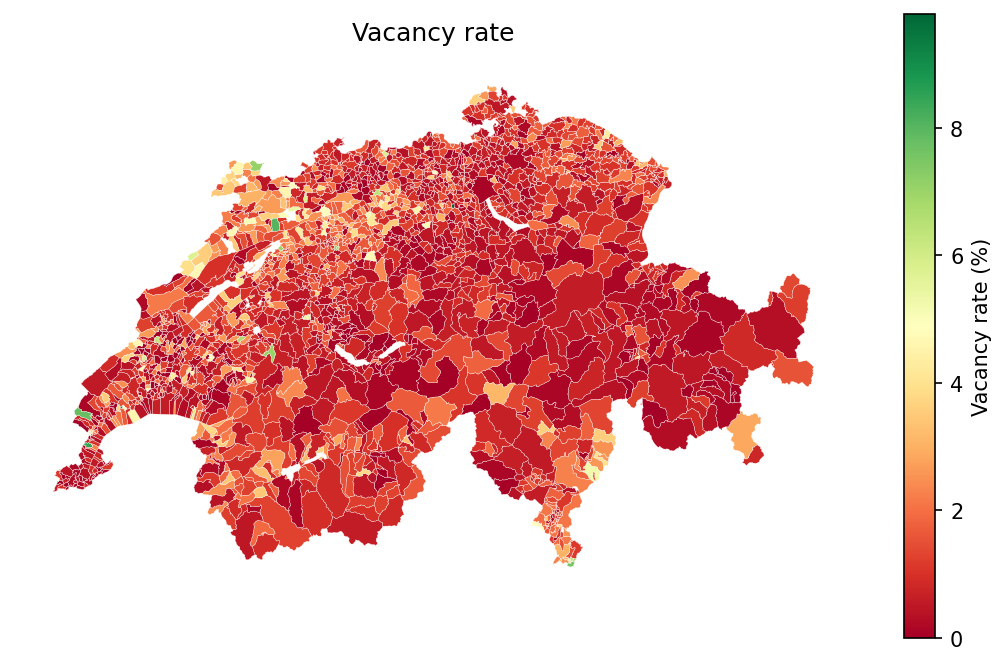

In [8]:
# 8A) PLOT — Vacancy choropleth (1 figure in this cell)

import matplotlib.pyplot as plt

g_plot = g.dropna(subset=["vacancy_pct"]).copy()
fig, ax = plt.subplots(figsize=(9, 9), dpi=150)
if len(g_plot):
    g_plot.to_crs(CRS_CH).plot(
        column="vacancy_pct", ax=ax, cmap="RdYlGn", edgecolor="white", linewidth=0.15,
        legend=True, legend_kwds={"label":"Vacancy rate (%)","shrink":0.6}
    )
    ax.set_axis_off()
    ax.set_title("Vacancy rate", pad=10)
else:
    ax.text(0.5, 0.5, "No vacancy data", ha="center", va="center")
    ax.set_axis_off()

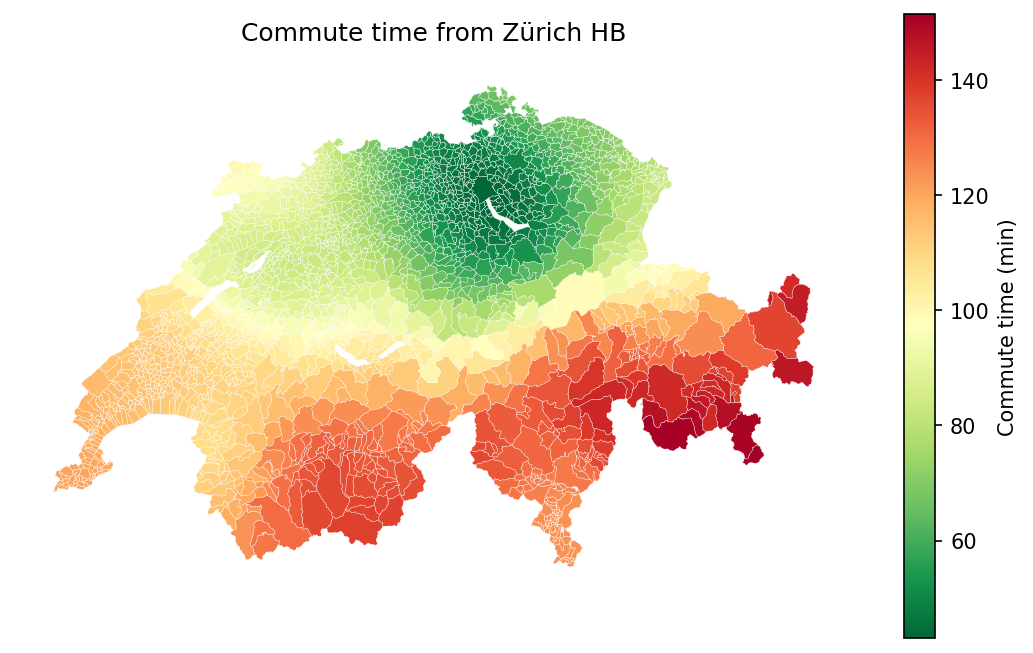

In [9]:
# 8B) PLOT — Commute time from origin (1 figure in this cell)

g_tt_plot = g.dropna(subset=["avg_travel_min"]).copy()
fig, ax = plt.subplots(figsize=(9, 9), dpi=150)
if len(g_tt_plot):
    g_tt_plot.to_crs(CRS_CH).plot(
        column="avg_travel_min", ax=ax, cmap="RdYlGn_r", edgecolor="white", linewidth=0.15,
        legend=True, legend_kwds={"label":"Commute time (min)","shrink":0.6}
    )
    ax.set_axis_off()
    ax.set_title(f"Commute time from {ORIGIN_STATION}", pad=10)
else:
    ax.text(0.5, 0.5, "No travel-time data", ha="center", va="center")
    ax.set_axis_off()

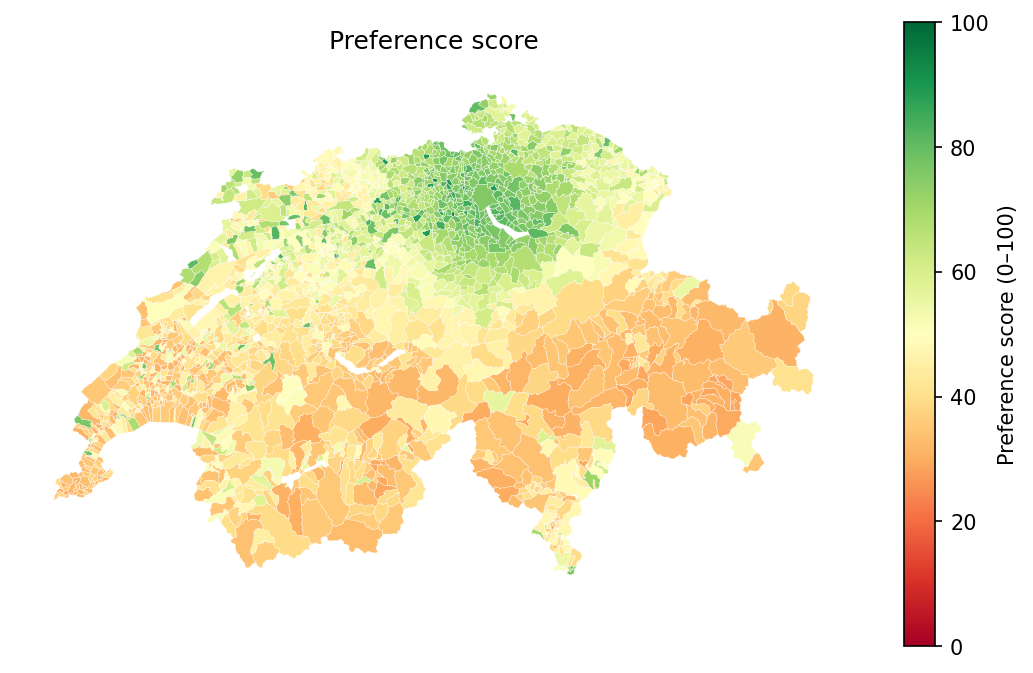

In [10]:
# 8C) PLOT — Preference score

g_ps = g.dropna(subset=["preference_score"]).copy()
fig, ax = plt.subplots(figsize=(9, 9), dpi=150)
if len(g_ps):
    g_ps.to_crs(CRS_CH).plot(
        column="preference_score", ax=ax, cmap="RdYlGn", edgecolor="white", linewidth=0.15,
        legend=True, vmin=0, vmax=100, legend_kwds={"label":"Preference score (0–100)","shrink":0.6}
    )
    ax.set_axis_off()
    ax.set_title("Preference score", pad=10)
else:
    ax.text(0.5, 0.5, "No preference scores", ha="center", va="center")
    ax.set_axis_off()